<a href="https://colab.research.google.com/github/kridtapon/Momentum-Strength-Cross/blob/main/Momentum_Strength_Cross.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.8/527.8 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.1 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# === Download data ===
symbol = 'AMGN'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# === MACD Function ===
def calculate_macd(close, fast_period=12, slow_period=26, signal_period=9):
    ema_fast = close.ewm(span=fast_period, adjust=False).mean()
    ema_slow = close.ewm(span=slow_period, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return macd_line, signal_line, macd_hist

# === ADX Function ===
def calculate_adx(high, low, close, period=14):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    minus_dm = minus_dm.abs()

    tr1 = high - low
    tr2 = (high - close.shift()).abs()
    tr3 = (low - close.shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()

    plus_di = 100 * (plus_dm.rolling(period).mean() / atr)
    minus_di = 100 * (minus_dm.rolling(period).mean() / atr)
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(period).mean()
    return adx

# === Calculate Indicators ===
df['MACD'], df['Signal'], df['MACD_Hist'] = calculate_macd(df['Close'])
df['ADX'] = calculate_adx(df['High'], df['Low'], df['Close'])

# === Entry & Exit Rules ===
df['MACD_CrossUp'] = (df['MACD'] > df['Signal']) & (df['MACD'] > 0) & (df['Signal'] > 0)
df['MACD_CrossDown'] = (df['MACD'] < df['Signal']) & (df['MACD'] < 0) & (df['Signal'] < 0)

df['Entry'] = df['MACD_CrossUp'] & (df['ADX'] > 15)
df['Exit'] = df['MACD_CrossDown'] & (df['ADX'] < 15)

# === Filter test period ===
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# === Simulate Portfolio ===
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# === Output Stats & Plot ===
print(portfolio.stats())
portfolio.plot().show()


/tmp/ipython-input-5-387316098.py:10: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Start                                2020-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1258 days 00:00:00
Start Value                                     100000.0
End Value                                  102643.891593
Total Return [%]                                2.643892
Benchmark Return [%]                           25.003534
Max Gross Exposure [%]                             100.0
Total Fees Paid                              2627.707184
Max Drawdown [%]                               29.646433
Max Drawdown Duration                 1120 days 00:00:00
Total Trades                                          14
Total Closed Trades                                   14
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                        50.0
Best Trade [%]                                 14.291875
Worst Trade [%]                

/tmp/ipython-input-9-1842871235.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Best MACD parameters: Fast       8.000000
Slow      24.000000
Signal     7.000000
Return     0.225318
Name: 16, dtype: float64


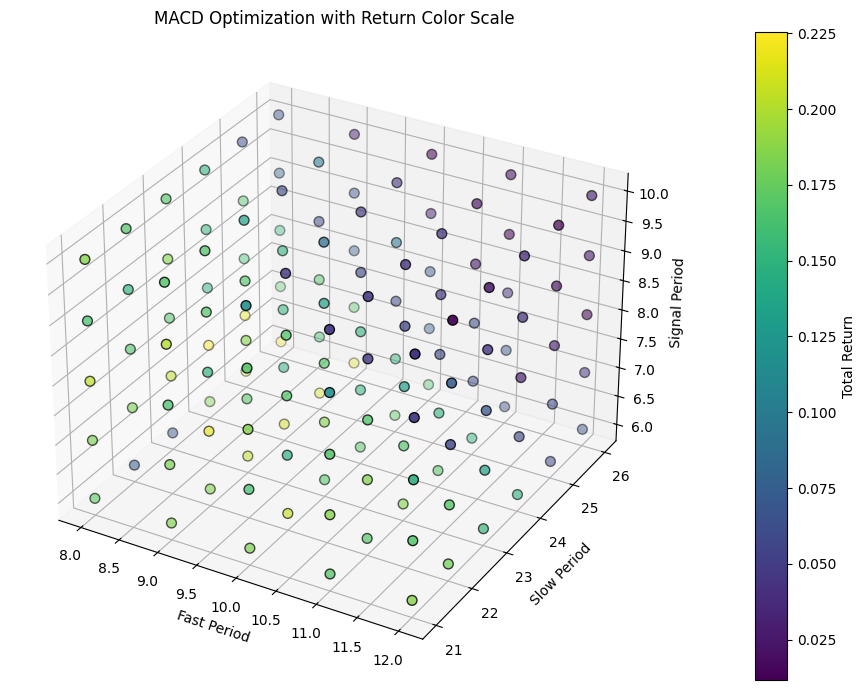

Best MACD + ADX parameters: MACD_Params      8-24-7
ADX_Period           11
Return         0.501168
Name: 337, dtype: object


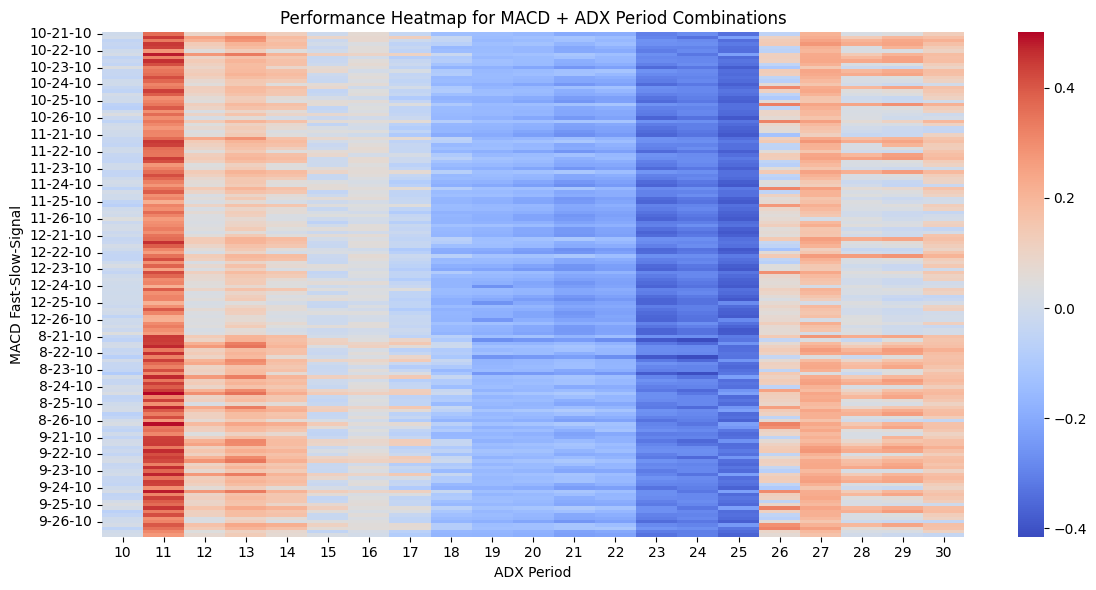

In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# === Download data ===
symbol = 'AMGN'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# === MACD Function ===
def calculate_macd(close, fast_period=12, slow_period=26, signal_period=9):
    ema_fast = close.ewm(span=fast_period, adjust=False).mean()
    ema_slow = close.ewm(span=slow_period, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return macd_line, signal_line, macd_hist

# === ADX Function ===
def calculate_adx(high, low, close, period=14):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    minus_dm = minus_dm.abs()

    tr1 = high - low
    tr2 = (high - close.shift()).abs()
    tr3 = (low - close.shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()

    plus_di = 100 * (plus_dm.rolling(period).mean() / atr)
    minus_di = 100 * (minus_dm.rolling(period).mean() / atr)
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(period).mean()
    return adx

# === Define parameter ranges ===
fast_range = range(8, 13)
slow_range = range(21, 27)
signal_range = range(6, 11)

results = []

# === Optimize MACD Parameters ===
for fast, slow, signal in itertools.product(fast_range, slow_range, signal_range):
    if fast >= slow:
        continue  # fast must be less than slow

    df['MACD'], df['Signal'], df['MACD_Hist'] = calculate_macd(df['Close'], fast, slow, signal)
    df['ADX'] = calculate_adx(df['High'], df['Low'], df['Close'])
    df['MACD_CrossUp'] = (df['MACD'] > df['Signal']) & (df['MACD'] > 0) & (df['Signal'] > 0)
    df['MACD_CrossDown'] = (df['MACD'] < df['Signal']) & (df['MACD'] < 0) & (df['Signal'] < 0)

    df['Entry'] = df['MACD_CrossUp'] & (df['ADX'] > 20)
    df['Exit'] = df['MACD_CrossDown'] & (df['ADX'] < 20)

    df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    entries = df_test['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
    exits = df_test['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

    pf = vbt.Portfolio.from_signals(df_test['Open'], entries, exits, init_cash=100_000, fees=0.001, slippage=0.002)
    total_return = pf.total_return()

    results.append((fast, slow, signal, total_return))

# === Find best combination ===
results_df = pd.DataFrame(results, columns=['Fast', 'Slow', 'Signal', 'Return'])
best_params = results_df.loc[results_df['Return'].idxmax()]
print("Best MACD parameters:", best_params)

# === Plot 3D Surface with Color Panel ===
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Use return values for color
sc = ax.scatter(
    results_df['Fast'],
    results_df['Slow'],
    results_df['Signal'],
    c=results_df['Return'],
    cmap='viridis',
    s=50,
    edgecolor='k'
)

ax.set_xlabel('Fast Period')
ax.set_ylabel('Slow Period')
ax.set_zlabel('Signal Period')
plt.title('MACD Optimization with Return Color Scale')

# Add colorbar
cbar = plt.colorbar(sc, pad=0.1)
cbar.set_label('Total Return')

plt.tight_layout()
plt.show()

import seaborn as sns

# === Define ADX period range ===
adx_range = range(10, 31)
macd_combos = results_df[['Fast', 'Slow', 'Signal']].drop_duplicates().values

heatmap_data = []

for fast, slow, signal in macd_combos:
    df['MACD'], df['Signal'], df['MACD_Hist'] = calculate_macd(df['Close'], fast, slow, signal)

    for adx_period in adx_range:
        df['ADX'] = calculate_adx(df['High'], df['Low'], df['Close'], adx_period)

        df['MACD_CrossUp'] = (df['MACD'] > df['Signal']) & (df['MACD'] > 0) & (df['Signal'] > 0)
        df['MACD_CrossDown'] = (df['MACD'] < df['Signal']) & (df['MACD'] < 0) & (df['Signal'] < 0)

        df['Entry'] = df['MACD_CrossUp'] & (df['ADX'] > 20)
        df['Exit'] = df['MACD_CrossDown'] & (df['ADX'] < 20)

        df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

        entries = df_test['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
        exits = df_test['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

        pf = vbt.Portfolio.from_signals(df_test['Open'], entries, exits, init_cash=100_000, fees=0.001, slippage=0.002)
        total_return = pf.total_return()

        heatmap_data.append((f'{fast}-{slow}-{signal}', adx_period, total_return))

# === Create heatmap ===
heatmap_df = pd.DataFrame(heatmap_data, columns=['MACD_Params', 'ADX_Period', 'Return'])
pivot_table = heatmap_df.pivot(index='MACD_Params', columns='ADX_Period', values='Return')

# === Find best parameters ===
best_combo = heatmap_df.loc[heatmap_df['Return'].idxmax()]
print("Best MACD + ADX parameters:", best_combo)

# === Plot heatmap ===
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=False, fmt=".2%", cmap='coolwarm')
plt.title('Performance Heatmap for MACD + ADX Period Combinations')
plt.xlabel('ADX Period')
plt.ylabel('MACD Fast-Slow-Signal')
plt.tight_layout()
plt.show()


In [10]:
# === Calculate Indicators ===
df['MACD'], df['Signal'], df['MACD_Hist'] = calculate_macd(df['Close'], fast_period=8, slow_period=24, signal_period=7)
df['ADX'] = calculate_adx(df['High'], df['Low'], df['Close'], period=11)

# === Entry & Exit Rules ===
df['MACD_CrossUp'] = (df['MACD'] > df['Signal']) & (df['MACD'] > 0) & (df['Signal'] > 0)
df['MACD_CrossDown'] = (df['MACD'] < df['Signal']) & (df['MACD'] < 0) & (df['Signal'] < 0)

df['Entry'] = df['MACD_CrossUp'] & (df['ADX'] > 20)
df['Exit'] = df['MACD_CrossDown'] & (df['ADX'] < 20)

# === Filter test period ===
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# === Simulate Portfolio ===
shifted_entries = df['Entry'].shift(1).astype(bool).fillna(False).to_numpy()
shifted_exits = df['Exit'].shift(1).astype(bool).fillna(False).to_numpy()

portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shifted_entries,
    exits=shifted_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# === Output Stats & Plot ===
print(portfolio.stats())
portfolio.plot().show()

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           150116.765344
Total Return [%]                        50.116765
Benchmark Return [%]                    25.003553
Max Gross Exposure [%]                      100.0
Total Fees Paid                       1837.380919
Max Drawdown [%]                        25.473059
Max Drawdown Duration           301 days 00:00:00
Total Trades                                    8
Total Closed Trades                             8
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 75.0
Best Trade [%]                          17.871417
Worst Trade [%]                        -10.278687
Avg Winning Trade [%]                     9.72259
Avg Losing Trade [%]                    -6.591501
